In [3]:
data = pd.read_csv('data/train.csv')
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


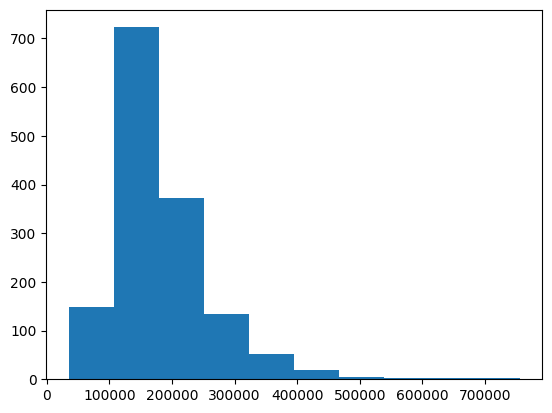

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46024211, 10.7676652 , 11.07508829, 11.38251138, 11.68993448,
        11.99735757, 12.30478066, 12.61220375, 12.91962684, 13.22704994,
        13.53447303]),
 <BarContainer object of 10 artists>)

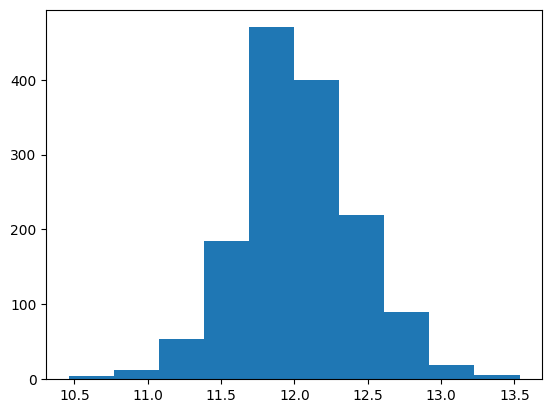

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

price = list(data.SalePrice)
plt.hist(price)
plt.show()
plt.hist(np.log(price))

In [73]:
import numpy as np
import pymc as pm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the dataset
data = pd.read_csv('data/train.csv')
data['PriceLogged'] = list(np.log(np.array(list(data.SalePrice)))) # log the price so it has a normal distribution

# Check column names and ensure the target column exists
print("Columns in dataset:", data.columns)
if 'SalePrice' not in data.columns:
    raise ValueError("Target column 'SalePrice' not found in the dataset. Please check the column names.")

# Separate features and target
# Ensure target is separated correctly
X = data.drop(columns=['SalePrice', 'PriceLogged'], errors='ignore')  # Drop target columns
y = data['PriceLogged']  # Use log-transformed price as target

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print("Numeric Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)

# Define preprocessing pipelines
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ]
)

# Fit and transform the data
X_transformed = preprocessor.fit_transform(X)

# Get feature names
categorical_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
processed_features = list(numeric_cols) + list(categorical_features)

# Convert transformed data to a DataFrame
X_df = pd.DataFrame(X_transformed, columns=processed_features)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

# Define the Bayesian model
# Define the Bayesian model
with pm.Model() as housing_model:
    # Priors for coefficients
    coefficients = pm.Normal('coefficients', mu=0, sigma=10, shape=X_train.shape[1])
    intercept = pm.Normal('Intercept', mu=0, sigma=10)

    # Define the linear model
    mu = pm.math.dot(X_train.values, coefficients) + intercept

    # Likelihood function
    sigma = pm.HalfNormal('sigma', sigma=10)
    price_obs = pm.Normal('Price', mu=mu, sigma=sigma, observed=y_train.values)

    # Sampling using MCMC
    trace = pm.sample(1000, tune=1000, random_seed=42, cores=1)


# Summarize posterior distributions
summary = pm.summary(trace)
print(summary)


Columns in dataset: Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'Gara

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefficients, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 513 seconds.


                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
coefficients[0]   -0.001  0.003  -0.007    0.005      0.000    0.000   
coefficients[1]   -0.028  0.021  -0.063    0.010      0.006    0.005   
coefficients[2]    0.006  0.005  -0.004    0.015      0.001    0.000   
coefficients[3]    0.021  0.006   0.009    0.032      0.001    0.001   
coefficients[4]    0.055  0.007   0.043    0.069      0.001    0.001   
...                  ...    ...     ...      ...        ...      ...   
coefficients[242]  0.022  0.033  -0.039    0.080      0.004    0.003   
coefficients[243]  0.059  0.016   0.029    0.089      0.002    0.002   
coefficients[244]  0.079  0.120  -0.144    0.292      0.037    0.033   
Intercept          8.904  0.402   8.089    9.595      0.221    0.173   
sigma              0.104  0.002   0.099    0.108      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
coefficients[0]        96.0     298.0   1.01  
coefficients[1]        11.0      25.0   1

In [74]:
import arviz as az
import numpy as np

# Get posterior summaries for coefficients
posterior_summary = az.summary(trace, var_names=["coefficients"])
posterior_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefficients[0],-0.001,0.003,-0.007,0.005,0.000,0.000,96.0,298.0,1.01
coefficients[1],-0.028,0.021,-0.063,0.010,0.006,0.005,11.0,25.0,1.17
coefficients[2],0.006,0.005,-0.004,0.015,0.001,0.000,69.0,129.0,1.01
coefficients[3],0.021,0.006,0.009,0.032,0.001,0.001,31.0,123.0,1.05
coefficients[4],0.055,0.007,0.043,0.069,0.001,0.001,50.0,182.0,1.03
...,...,...,...,...,...,...,...,...,...
coefficients[240],0.092,0.066,-0.032,0.210,0.006,0.005,107.0,146.0,1.01
coefficients[241],0.173,0.057,0.067,0.294,0.012,0.009,24.0,62.0,1.10
coefficients[242],0.022,0.033,-0.039,0.080,0.004,0.003,66.0,170.0,1.05
coefficients[243],0.059,0.016,0.029,0.089,0.002,0.002,68.0,181.0,1.05


In [75]:
not_0_coeffs = np.where(np.array(list(posterior_summary['mean'])) > 0)[0]
important_features = [list(X_train.columns)[i] for i in not_0_coeffs]

best_features_coeffs = posterior_summary.iloc[not_0_coeffs]
best_features_coeffs['feature_names'] = important_features
best_features_coeffs

/var/folders/yn/bkfdzjnd0y78gcz28ddlslhr0000gn/T/ipykernel_28999/1923153302.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_features_coeffs['feature_names'] = important_features


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,feature_names
coefficients[2],0.006,0.005,-0.004,0.015,0.001,0.000,69.0,129.0,1.01,LotFrontage
coefficients[3],0.021,0.006,0.009,0.032,0.001,0.001,31.0,123.0,1.05,LotArea
coefficients[4],0.055,0.007,0.043,0.069,0.001,0.001,50.0,182.0,1.03,OverallQual
coefficients[5],0.040,0.005,0.031,0.050,0.001,0.001,36.0,135.0,1.07,OverallCond
coefficients[6],0.061,0.012,0.037,0.081,0.002,0.001,43.0,139.0,1.04,YearBuilt
...,...,...,...,...,...,...,...,...,...,...
coefficients[240],0.092,0.066,-0.032,0.210,0.006,0.005,107.0,146.0,1.01,SaleCondition_AdjLand
coefficients[241],0.173,0.057,0.067,0.294,0.012,0.009,24.0,62.0,1.10,SaleCondition_Alloca
coefficients[242],0.022,0.033,-0.039,0.080,0.004,0.003,66.0,170.0,1.05,SaleCondition_Family
coefficients[243],0.059,0.016,0.029,0.089,0.002,0.002,68.0,181.0,1.05,SaleCondition_Normal


In [84]:
best_features_coeffs.sort_values(by='mean', ascending=False).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,feature_names
coefficients[16],6.574,6.086,-4.388,16.414,3.525,2.787,3.0,17.0,1.78,GrLivArea
coefficients[114],2.881,0.209,2.470,3.242,0.073,0.054,8.0,64.0,1.19,RoofMatl_Roll
coefficients[113],2.870,0.229,2.430,3.277,0.077,0.056,9.0,68.0,1.21,RoofMatl_Metal
coefficients[117],2.829,0.197,2.459,3.160,0.074,0.055,8.0,21.0,1.22,RoofMatl_WdShngl
coefficients[116],2.825,0.205,2.390,3.159,0.072,0.054,8.0,36.0,1.19,RoofMatl_WdShake
coefficients[111],2.802,0.175,2.473,3.111,0.054,0.040,11.0,31.0,1.16,RoofMatl_CompShg
coefficients[115],2.721,0.185,2.388,3.097,0.078,0.058,6.0,46.0,1.31,RoofMatl_Tar&Grv
coefficients[135],2.505,6.329,-8.851,13.953,0.875,0.622,53.0,95.0,1.03,Exterior2nd_CBlock
coefficients[9],0.547,5.518,-7.955,12.389,2.463,1.854,5.0,33.0,1.33,BsmtFinSF1
coefficients[11],0.506,5.346,-7.749,11.980,2.387,1.797,5.0,33.0,1.33,BsmtUnfSF


In [86]:
from sklearn.linear_model import LassoCV

# Train Lasso model with cross-validation
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

# Get feature importance
lasso_coefficients = pd.Series(lasso.coef_, index=X_train.columns)
important_features = lasso_coefficients[lasso_coefficients != 0]

print("Lasso Selected Features:\n", important_features)


Lasso Selected Features:
 Id                      -0.002584
MSSubClass              -0.028059
LotFrontage             -0.009468
LotArea                  0.014034
OverallQual              0.094671
                           ...   
PavedDrive_Y             0.005159
Fence_GdWo              -0.004636
Fence_MnPrv              0.009017
SaleCondition_Normal     0.011267
SaleCondition_Partial    0.037331
Length: 74, dtype: float64


In [87]:
important_features

Id                      -0.002584
MSSubClass              -0.028059
LotFrontage             -0.009468
LotArea                  0.014034
OverallQual              0.094671
                           ...   
PavedDrive_Y             0.005159
Fence_GdWo              -0.004636
Fence_MnPrv              0.009017
SaleCondition_Normal     0.011267
SaleCondition_Partial    0.037331
Length: 74, dtype: float64

In [76]:
import numpy as np

# Step 1: Convert X_test to NumPy for matrix operations
X_test_np = X_test.values  # Shape: (n_test, n_features)

# Step 2: Extract posterior samples for coefficients and intercept
coefficients_samples = trace.posterior['coefficients'].values  # Shape: (chains, draws, n_features)
intercept_samples = trace.posterior['Intercept'].values  # Shape: (chains, draws)

# Flatten the samples (combine chains and draws)
coefficients_samples = coefficients_samples.reshape(-1, coefficients_samples.shape[-1])  # Shape: (n_samples, n_features)
intercept_samples = intercept_samples.flatten()  # Shape: (n_samples,)

# Debugging Shapes
print("Shape of coefficients_samples:", coefficients_samples.shape)  # (n_samples, n_features)
print("Shape of intercept_samples:", intercept_samples.shape)  # (n_samples,)
print("Shape of X_test_np:", X_test_np.shape)  # (n_test, n_features)

# Step 3: Compute predictions
# Dot product of posterior samples with X_test, plus intercept
predictions = np.dot(coefficients_samples, X_test_np.T) + intercept_samples[:, None]  # Shape: (n_samples, n_test)

# Step 4: Calculate mean and credible intervals for predictions
predicted_mean = predictions.mean(axis=0)  # Mean prediction for each test point
credible_intervals = np.percentile(predictions, [2.5, 97.5], axis=0)  # 95% credible intervals

# Step 5: Display predictions
actual_values = list(y_test)
for i, (mean, ci) in enumerate(zip(predicted_mean, credible_intervals.T)):
    print(f"Test Row {i}: Predicted Mean = {mean:.2f}, 95% CI = ({ci[0]:.2f}, {ci[1]:.2f})")

    print('\tactual_value --> ', actual_values[i])

Shape of coefficients_samples: (2000, 245)
Shape of intercept_samples: (2000,)
Shape of X_test_np: (292, 245)
Test Row 0: Predicted Mean = 11.94, 95% CI = (11.88, 12.00)
	actual_value -->  11.947949375319936
Test Row 1: Predicted Mean = 12.75, 95% CI = (12.69, 12.81)
	actual_value -->  12.691580461311874
Test Row 2: Predicted Mean = 11.49, 95% CI = (11.40, 11.57)
	actual_value -->  11.652687407345388
Test Row 3: Predicted Mean = 12.02, 95% CI = (11.93, 12.11)
	actual_value -->  11.976659481202368
Test Row 4: Predicted Mean = 12.66, 95% CI = (12.57, 12.76)
	actual_value -->  12.661913960963405
Test Row 5: Predicted Mean = 11.31, 95% CI = (11.20, 11.41)
	actual_value -->  11.231887935237117
Test Row 6: Predicted Mean = 12.43, 95% CI = (12.36, 12.51)
	actual_value -->  12.649154617209645
Test Row 7: Predicted Mean = 11.89, 95% CI = (11.78, 12.00)
	actual_value -->  11.891361900690473
Test Row 8: Predicted Mean = 11.25, 95% CI = (11.14, 11.36)
	actual_value -->  11.344506813345266
Test Row

In [77]:
rss = np.sum(np.square(np.round(np.exp(actual_values)) - np.round(np.exp(predicted_mean))))

mse = rss / len(y_test)
print(f"Mean Squared Error (MSE): {mse:.2f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Squared Error (MSE): 665309903.16
Root Mean Squared Error (RMSE): 25793.60


In [78]:
print("Number of rows in training set:", X_train.shape[0])
print("Number of rows in test set:", X_test.shape[0])
print("Overlap between train and test sets:", set(X_train.index) & set(X_test.index))


Number of rows in training set: 1168
Number of rows in test set: 292
Overlap between train and test sets: set()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (247) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'coefficients\n0'}>,
        <Axes: title={'center': 'coefficients\n1'}>,
        <Axes: title={'center': 'coefficients\n2'}>,
        <Axes: title={'center': 'coefficients\n3'}>],
       [<Axes: title={'center': 'coefficients\n4'}>,
        <Axes: title={'center': 'coefficients\n5'}>,
        <Axes: title={'center': 'coefficients\n6'}>,
        <Axes: title={'center': 'coefficients\n7'}>],
       [<Axes: title={'center': 'coefficients\n8'}>,
        <Axes: title={'center': 'coefficients\n9'}>,
        <Axes: title={'center': 'coefficients\n10'}>,
        <Axes: title={'center': 'coefficients\n11'}>],
       [<Axes: title={'center': 'coefficients\n12'}>,
        <Axes: title={'center': 'coefficients\n13'}>,
        <Axes: title={'center': 'coefficients\n14'}>,
        <Axes: title={'center': 'coefficients\n15'}>],
       [<Axes: title={'center': 'coefficients\n16'}>,
        <Axes: title={'center': 'coefficients\n17'}>,
        <Axes: title={'center': 'c

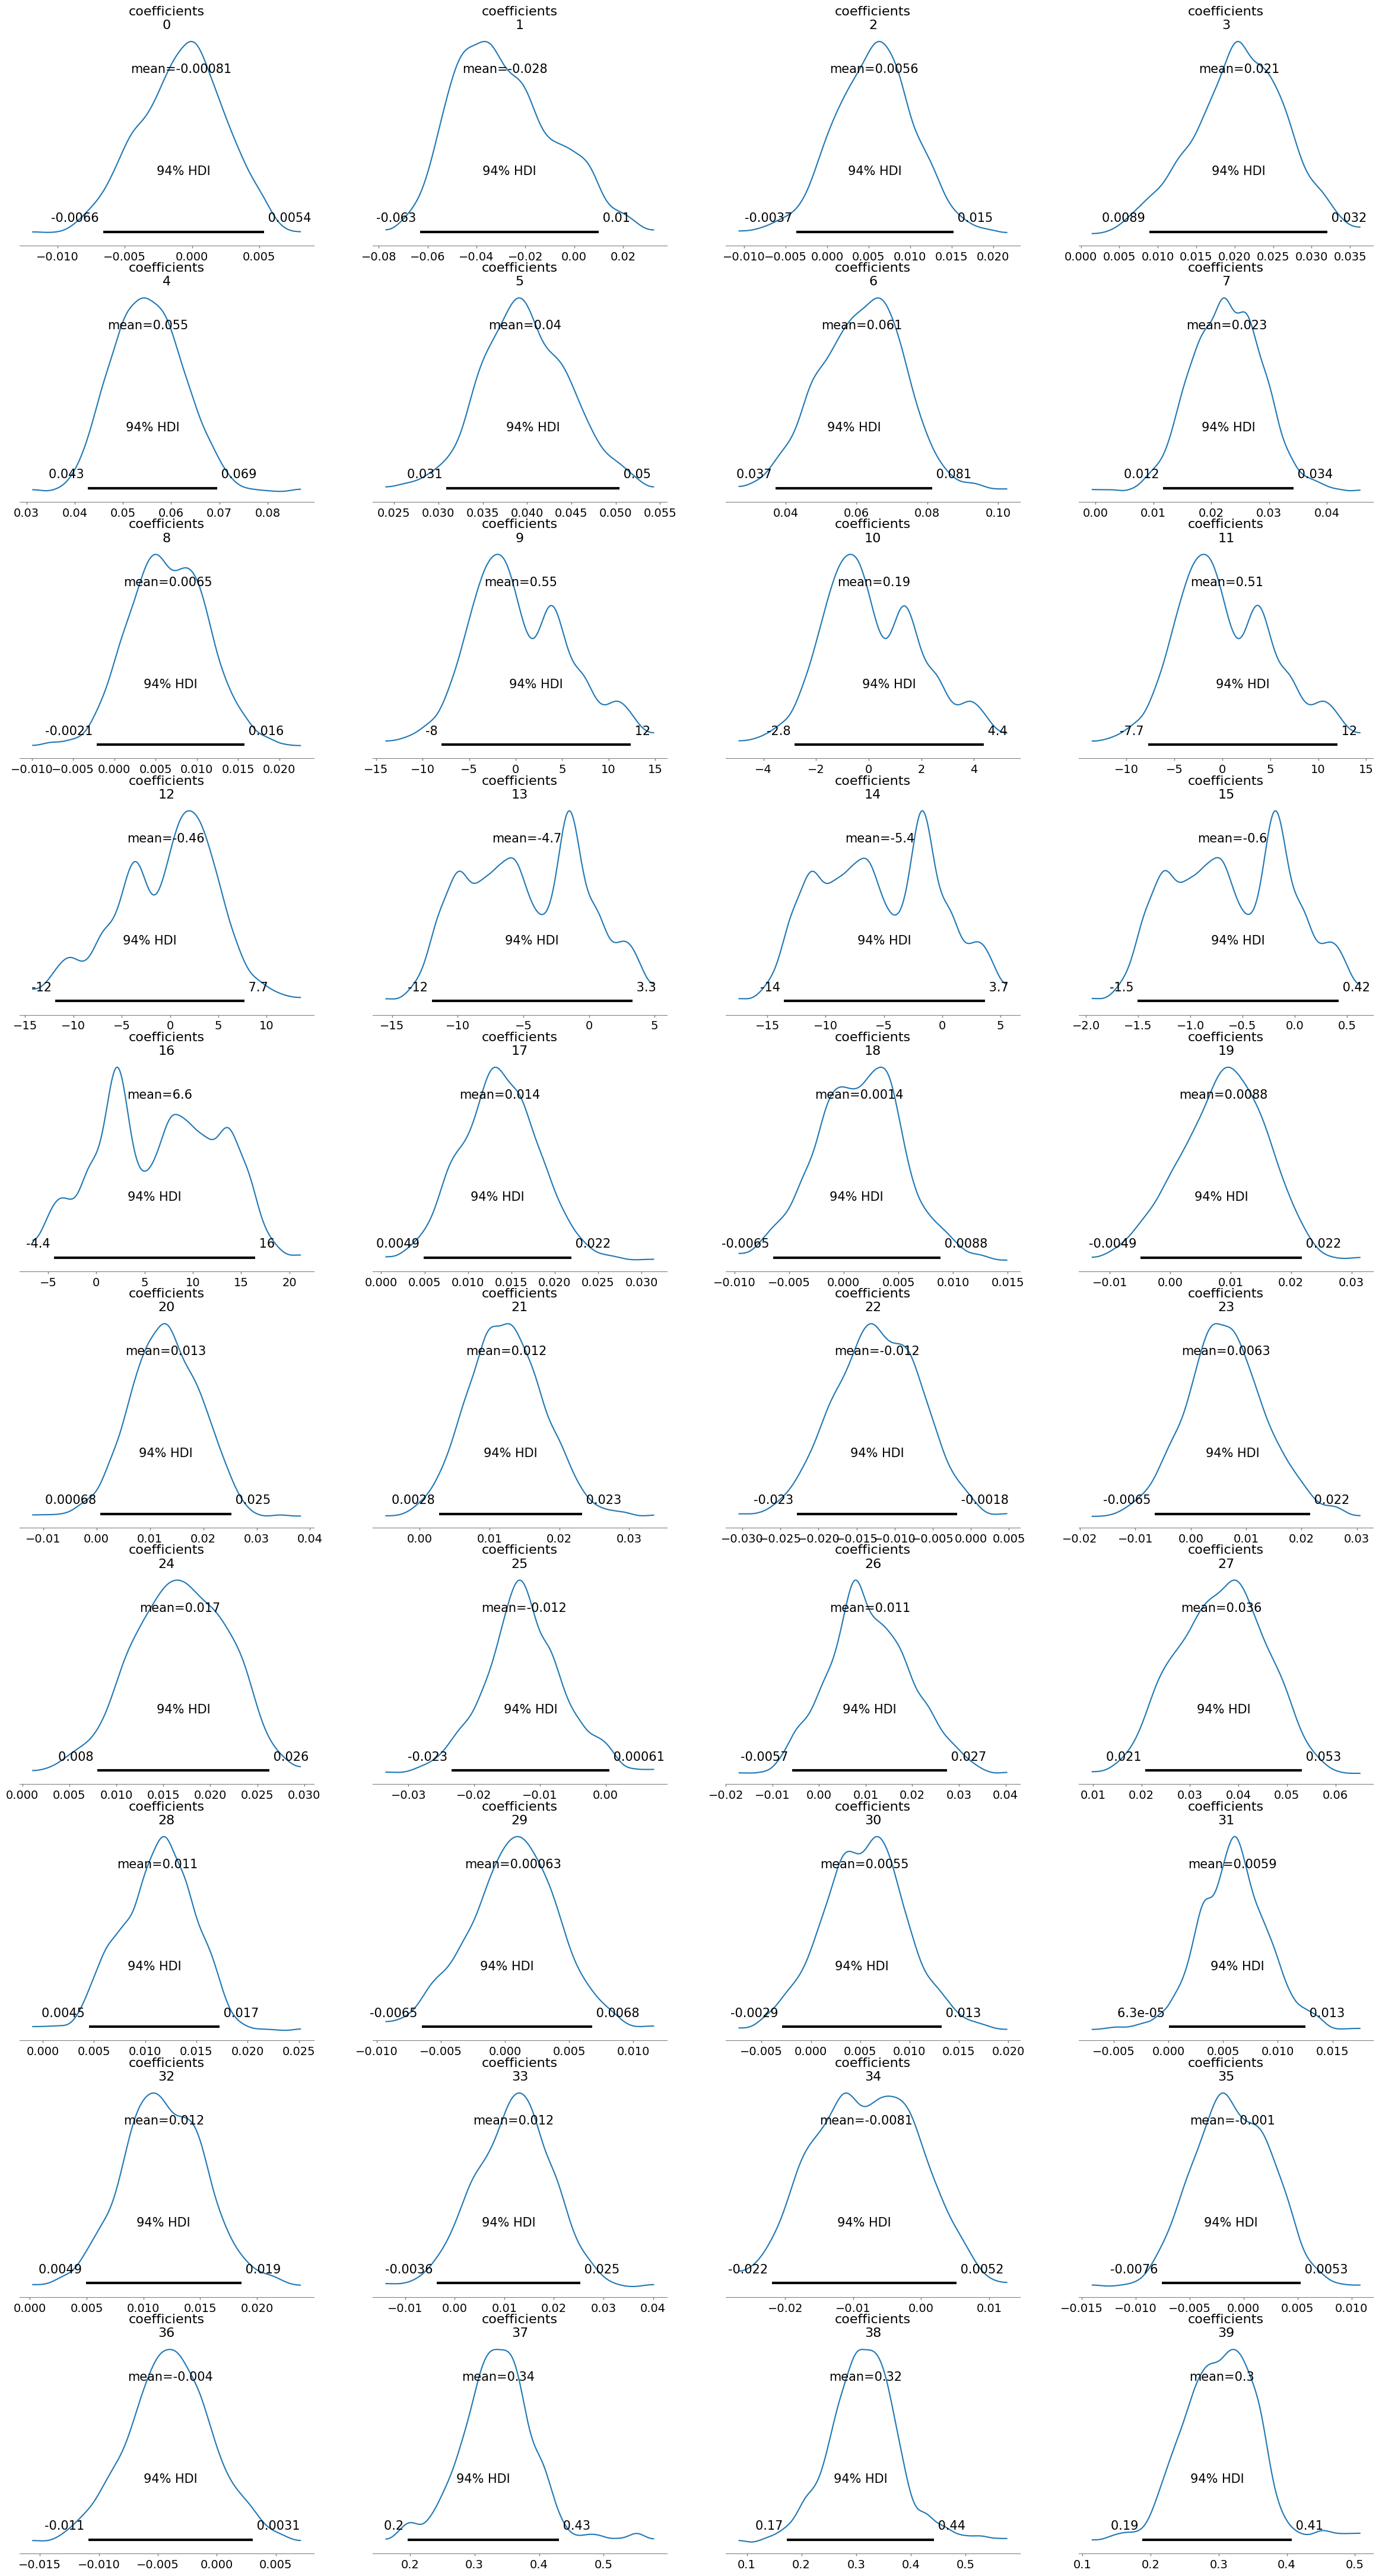

In [79]:
import arviz as az
az.plot_posterior(trace)


In [85]:
# Predictions for training set
train_predictions = np.dot(coefficients_samples, X_train.values.T) + intercept_samples[:, None]
train_predicted_mean = train_predictions.mean(axis=0)

# Compare RMSE for train and test
train_rmse = np.sqrt(np.mean((np.exp(y_train) - np.exp(train_predicted_mean)) ** 2))
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {rmse:.2f}")


Training RMSE: 17461.91
Test RMSE: 25793.60


In [50]:
print(trace.posterior['coefficients'].shape[-1])


246


## Why use normal distribution for the priors:
Rationale: Normal priors are used here because they encode the belief that the parameter values are most likely to cluster around a central value (e.g., 0) but with some spread (controlled by the standard deviation, sigma).
- #### Why It's Relevant:
        - Most effects in real-world data tend to cluster around a central value (e.g., the effect of neighborhood or room size). The Normal distribution is flexible, allowing you to encode both uncertainty (using large sigma) and prior knowledge (using a specific mean, mu).